In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os.path
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from pandas.tseries.offsets import MonthEnd
import math
from windrose import WindroseAxes

In [2]:
def calc_intra_annual(df, mean_col, min_col=None, max_col=None, v=False):
    df["DAY"] = df.index.dayofyear
    # next we need to eliminate Feb 29th: 
    df["DAY"] = np.where(df.index.is_leap_year & (df.index.month > 2), df["DAY"] - 1, df["DAY"])  # we just ignore the existence of 29th Feb
    # display(df.loc[(df["DAY"] > 59) & (df["DAY"] <= 61)])
    
    params = ["mean", "std"]
    col_dict = {mean_col: params}
    if min_col is None:
        params.append("min")
    else:
        col_dict[min_col] = "min"
    if max_col is None:
        params.append("max")
    else:
        col_dict[max_col] = "max"
    
    out_df = df.groupby("DAY").agg(col_dict)
    out_df.columns = ("mean", "std", "min", "max")  # "flattens" grouped columns

    out_df["upper"] = out_df["mean"] + out_df["std"]
    out_df["lower"] = out_df["mean"] - out_df["std"]
    
    # checking if the upper and lower values are within max-min limits:
    out_df["upper"] = np.where(out_df["upper"] > out_df["max"], out_df["max"], out_df["upper"])
    out_df["lower"] = np.where(out_df["lower"] < out_df["min"], out_df["min"], out_df["lower"])
    if v:
        display(out_df)
    return out_df


def plot_intra_annual(df, ax):
    ax.fill_between(df.index, df["upper"], df["lower"], color="lightgrey", label="±SD")
    ax.plot(df.index, df["max"], color="grey", linewidth=1, label="max/min")
    ax.plot(df.index, df["min"], color="grey", linewidth=1)
    ax.plot(df.index, df["mean"], color="k", linewidth=1, label="mean")

    
def mark_axes(ax_tuple, px=-0.1, py=1.15):
    letter = "a"
    for ax in ax_tuple:
        ax.text(px, py, "(%s)" % letter, transform=ax.transAxes, fontsize=MEDIUM_SIZE, va='top', ha='right')
        letter = chr(ord(letter) + 1)  # increments the letter in alphabetical order

        
def monthly_ticks(ax, crop=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))  # 16 is a slight approximation since months differ in number of days

    ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

    for tick in ax.xaxis.get_minor_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment("center")
    ax.xaxis.get_minor_ticks()[-1].set_visible(False)
    if crop:
        ax.xaxis.get_minor_ticks()[0].set_visible(False)


In [3]:
cm = 1 / 2.54  # inches to cm
wu = 8.5*cm  # width unit
hu = 6*cm  # height unit

LEAST_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

matplotlib.rc('font', size=SMALL_SIZE)          # controls default text sizes
matplotlib.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=LEAST_SIZE)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
matplotlib.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Wind roses:

Let's examine the data from the Barentsburg weather station

In [25]:
fig_dir = os.path.join(globals()['_dh'][0], "fig")

in_file = os.path.join(globals()['_dh'][0], "data/wr101248a2.csv")
print(in_file)

dt_parser = lambda x: datetime.strptime(x, "%Y %m %d %H")
# dt_parser = lambda dates: [datetime.strptime(x, "%Y %m %d %H") for x in dates]

tmp = pd.read_csv(in_file, comment="#", parse_dates= {"DATE" : ["YEAR", "MONTH", "DAY", "HOUR"]}, date_parser=dt_parser)
tmp.set_index(tmp["DATE"], inplace=True)
# tmp = pd.read_csv(in_file, comment="#")

# tmp['date'] = pd.to_datetime(tmp[['MONTH','DAY','YEAR']])

tmp.info()

display(tmp)

/home/antonv/PycharmProjects/barentsburg-meteo/data/wr101248a2.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156808 entries, 1965-12-31 21:00:00 to 2021-06-30 18:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   DATE         156808 non-null  datetime64[ns]
 1   WMO_ID       156808 non-null  int64         
 2   YEAR_L       156808 non-null  int64         
 3   MONTH_L      156808 non-null  int64         
 4   DAY_L        156808 non-null  int64         
 5   HOUR_L       156808 non-null  int64         
 6   WIND_DIR     156801 non-null  float64       
 7   WIND_SPEED   156802 non-null  float64       
 8   MAX_SPEED    124634 non-null  float64       
 9   Unnamed: 12  0 non-null       float64       
dtypes: datetime64[ns](1), float64(4), int64(5)
memory usage: 13.2 MB


,DATE,WMO_ID,YEAR_L,MONTH_L,DAY_L,HOUR_L,WIND_DIR,WIND_SPEED,MAX_SPEED,Unnamed: 12
DATE,,,,,,,,,,
1965-12-31 21:00:00,1965-12-31 21:00:00,20107,1966,1,1,0,0.0,0.0,NaN,NaN
1966-01-01 00:00:00,1966-01-01 00:00:00,20107,1966,1,1,3,0.0,0.0,NaN,NaN
1966-01-01 03:00:00,1966-01-01 03:00:00,20107,1966,1,1,6,0.0,0.0,NaN,NaN
1966-01-01 06:00:00,1966-01-01 06:00:00,20107,1966,1,1,9,0.0,0.0,NaN,NaN
1966-01-01 09:00:00,1966-01-01 09:00:00,20107,1966,1,1,12,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-06-30 06:00:00,2021-06-30 06:00:00,20107,2021,6,30,6,169.0,5.0,8.0,NaN
2021-06-30 09:00:00,2021-06-30 09:00:00,20107,2021,6,30,9,176.0,5.0,9.0,NaN
2021-06-30 12:00:00,2021-06-30 12:00:00,20107,2021,6,30,12,163.0,6.0,9.0,NaN


(0, 3, 5, 8, 10)


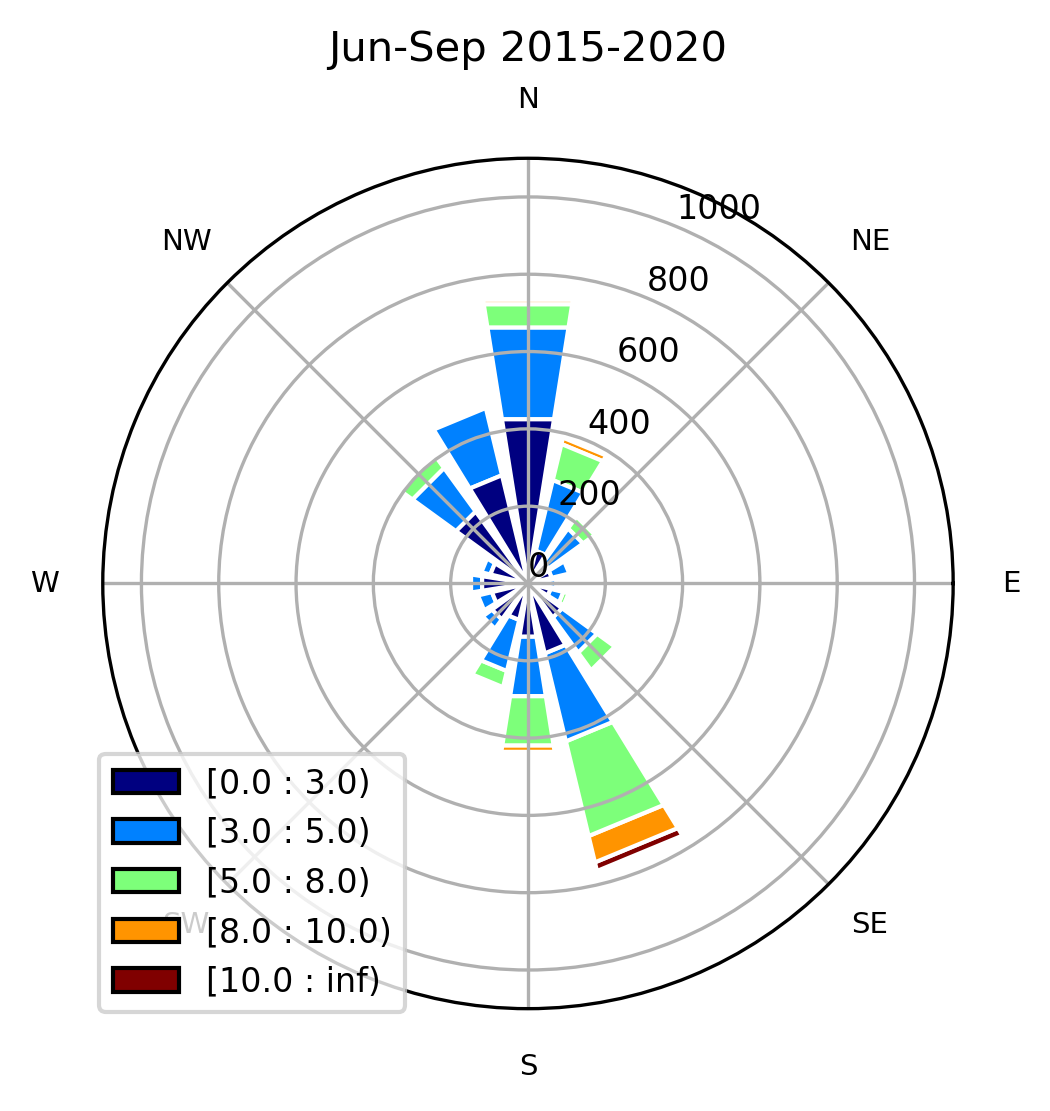

In [95]:
start_year = 2015
end_year = start_year + 5

df = tmp.loc[(tmp.index.year >= start_year) & (tmp.index.year < end_year)]
df = df.loc[df.index.month.isin((6, 7, 8, 9))]
# display(df)

fig = plt.figure(figsize=(1.5*wu, 1.5*hu), dpi=300, facecolor='w', edgecolor='w')
rect = [0.1, 0.1, 0.8, 0.8]
ax = WindroseAxes(fig, rect)
fig.add_axes(ax)

bins = np.arange(0, 15, 4)
bins = (0, 3, 5, 8, 10)
print(bins)
ax.bar(df["WIND_DIR"], df["WIND_SPEED"], normed=False, opening=0.8, bins=bins, edgecolor='white')
ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
ax.set_ylim(0, 1100)
ax.set_yticks(np.arange(0, 1100, step=200))
ax.set_yticklabels(np.arange(0, 1100, step=200))
ax.set_legend()
ax.set_title("Jun-Sep %s-%s" % (start_year, end_year));

fig_path = os.path.join(fig_dir, "windrose_%s-%s.png" % (start_year, end_year))
plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white", bbox_inches='tight')

In [ ]:
"""
df = avg_df

df = df.loc[df.index.year >= 2000]

def new_axes():
    fig = plt.figure(figsize=(1.5*wu, 1.5*hu), dpi=300, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect)
    fig.add_axes(ax)
    return fig, ax

for y in range(2001, 2021):
    test = df.loc[((df.index.year == y) & (df.index.month.isin((1, 2, 3, 4))) | ((df.index.year == (y - 1)) & (df.index.month.isin((10, 11, 12)))))]

    fig, ax = new_axes()
    ax.bar(test["WD_MEAN"], test["WS_MEAN"], normed=False, opening=0.8, bins=np.arange(0, 25, 5), edgecolor='white')
    ax.set_xticklabels(['E', 'NE', 'N', 'NW',  'W', 'SW', 'S', 'SE'])
    ax.set_yticks(np.arange(10, 60, step=10))
    ax.set_yticklabels(np.arange(10, 60, step=10))
    ax.set_legend()
    ax.set_title("%s-%s" % (y - 1, y))
    
    # fig.tight_layout()
    # fig_path = os.path.join(fig_dir, "windrose_%s-%s.png" % (y - 1, y))
    # plt.savefig(fig_path, dpi=300, transparent=False, facecolor="white")
"""